In [1]:
scan_fov = 4.7
scan_beams = 1080
angle_min = -scan_fov/2.
angle_max = scan_fov/ 2.
angle_inc = scan_fov / scan_beams

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import pickle

In [3]:
def polar_to_cart(theta, r):
    """
    Assumes theta in radians & returns x,y
    """
    x = r*np.cos(theta)
    y = r*np.sin(theta)
    return x,y
    
def lidar_polar_to_cart(ranges, angle_min, angle_increment):
    """
    Convert a lidar_dict to cartesian & return x_ranges & y_ranges
    """
    x_ranges = []
    y_ranges = []
    for i, r in enumerate(ranges):
        if r == np.nan:
            x_ranges.append(1000000)
            y_ranges.append(1000000)
        else:
            theta = angle_min + i * angle_increment
            x, y = polar_to_cart(theta + math.pi/2, r*100.0)
            x_ranges.append(x)
            y_ranges.append(y)
    return x_ranges, y_ranges

In [4]:
folderpath = '../data/sim_train/'
pkl_list = os.listdir(folderpath)
pkl_list.sort()
pkl_list = pkl_list[:]

In [5]:
X = np.zeros((len(pkl_list), 1080))
steers = []
for i, pkl_name in enumerate(pkl_list):
    with open(os.path.join(folderpath, pkl_name), 'rb') as f:
        pkl_dict = pickle.load(f)
        obs = pkl_dict.get("obs")
        act = pkl_dict.get("action")
        scans = obs["scans"]
        X[i, :] = np.array(scans)
        steers.append(act["angle"])

In [15]:
from sklearn.cluster import KMeans
km = KMeans(
    n_clusters=10, init='random',
    n_init=10, max_iter=1000,
)
y_km = km.fit_predict(X)

In [16]:
pickle.dump(km, open('../models/1/knn_model3', 'wb')) 

In [ ]:
km = pickle.load(open('../models/1/knn_model', 'rb'))
centers = km.cluster_centers_
for i in range(len(centers)):
    ranges = centers[i, :]
    xranges, yranges = lidar_polar_to_cart(ranges, angle_min, angle_inc)
    plt.scatter(xranges, yranges)

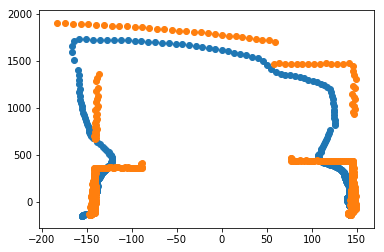

In [22]:
idx = 0
out = km.predict(X)
center0 = centers[out[idx], :]
xranges, yranges = lidar_polar_to_cart(center0, angle_min, angle_inc)
plt.scatter(xranges, yranges)

ranges = X[idx, :]
xranges, yranges = lidar_polar_to_cart(ranges, angle_min, angle_inc)
plt.scatter(xranges, yranges)

RNG:25.432959906084882, MEAN:1.6615095512876012, MAX:17.204649348233904, MIN:-8.228310557850978
RNG:24.435588929375676, MEAN:-3.2475574989677725, MAX:8.228310557851003, MIN:-16.207278371524673
RNG:22.44084697595724, MEAN:-0.5970980970817691, MAX:11.719108976333235, MIN:-10.721737999624004
RNG:28.207561080653583, MEAN:7.518865187642172, MAX:19.48056503444799, MIN:-8.726996046205594
RNG:27.42770185950329, MEAN:2.8712751428309575, MAX:17.703334836588493, MIN:-9.724367022914798


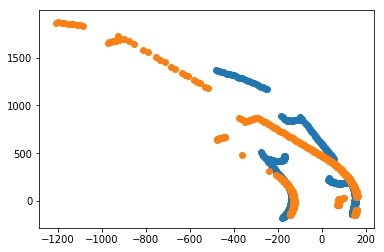

In [24]:
import scipy.stats
matches = np.array(out)
steers = np.array(steers)
output_angles = []
for i in range(len(centers)):
    true_idxs = np.nonzero((matches == i))[0]
    true_steers = steers[true_idxs]
    rng = np.max(true_steers) - np.min(true_steers)
    mean = np.mean(true_steers)
    count = scipy.stats.binned_statistic(true_steers, true_steers, statistic='count', bins=7)
    max_bin_idx = np.argmax(count.statistic)
    angle = count.bin_edges[max_bin_idx] + (count.bin_edges[max_bin_idx+1] - count.bin_edges[max_bin_idx])/2.
    # plt.hist(true_steers, bins=7)
    # plt.show()
    print(f"RNG:{rng}, MEAN:{mean}, MAX:{np.max(true_steers)}, MIN:{np.min(true_steers)}")
    output_angles.append(i)
argmax, argmin = np.argmax(true_steers), np.argmin(true_steers)
max_idx, min_idx = true_idxs[argmax], true_idxs[argmin]
max_scan, min_scan = X[max_idx, :], X[min_idx, :]
xmax, ymax = lidar_polar_to_cart(max_scan, angle_min, angle_inc)
xmin, ymin = lidar_polar_to_cart(min_scan, angle_min, angle_inc)

plt.scatter(xmax, ymax)
plt.scatter(xmin, ymin)

In [25]:
scan1 = X[8197, :][None]
print(scan1.shape)
out = km.predict(scan1)
print(out)

(1, 1080)
[0]
